<a href="https://colab.research.google.com/github/therobinkay/gender_bias_2021/blob/main/Journal_Analysis_2_(GitHub).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import io
import pandas as pd
import os
import itertools
import numpy as np
import scipy.stats
import time

import matplotlib.pyplot as plt
import seaborn as sns

import statistics
import math

from tqdm.auto import tqdm

import networkx as nx
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!cd "drive/My Drive"

In [ ]:
data = pd.read_csv("drive/My Drive/codes/data.csv")
# dp = pd.read_csv("drive/My Drive/codes/doipacs.csv")
cen = pd.read_csv('drive/My Drive/codes/cen.csv')

# cdata = pd.read_csv('drive/My Drive/codes/cdata.csv')

cb = pd.read_csv("drive/My Drive/codes/citationBara.csv")
cb['pair'] = "(" + cb["citing_doi"] + ", " + cb["cited_doi"] + ")"
cb['pair2'] = "(" + cb["cited_doi"] + ", " + cb["citing_doi"] + ")"

In [ ]:
############## SELECT DESIRED PACS (HOMOPHILY ONLY) ###############

# homn = pd.read_csv("drive/My Drive/codes/hom0.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom1.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom2.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom3.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom4.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom5.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom6.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom7.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom8.csv")
homn = pd.read_csv("drive/My Drive/codes/hom9.csv")

print(len(homn))
homn.head()

103313


,paper1,gender1,year1,paper2,gender2,year2,qval,k
0,10.1103/PhysRevA.35.4035,male,1987,10.1103/PhysRevA.36.4163,male,1987,0.001441,False
1,10.1103/PhysRevA.36.4700,male,1987,10.1103/PhysRevA.38.1839,male,1988,0.003817,True
2,10.1103/PhysRevA.36.4700,male,1987,10.1103/PhysRevA.40.6260,male,1989,0.003817,True
3,10.1103/PhysRevA.38.1839,male,1988,10.1103/PhysRevA.40.6260,male,1989,0.000015,True
4,10.1103/PhysRevA.36.4700,male,1987,10.1103/PhysRevA.40.6931,male,1989,0.003817,True


# 1. Year Diff. vs. Centrality Diff.

In [ ]:
dc = data[["doi", "year"]].drop_duplicates(subset = 'doi')
dc = dc.merge(cb, left_on = 'doi',
              right_on = 'citing_doi', how = 'inner').drop(
                  ['doi'], axis=1).rename({'year': 'citing_year'}, axis=1)

cols = ['citing_doi', 'citing_year', 'cited_doi']
dc = dc.reindex(columns=cols).sort_values('cited_doi')

In [ ]:
hom_mf = homn[homn["gender1"] != homn["gender2"]].reset_index(drop=True)

test = hom_mf.merge(dc, left_on = 'paper1',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper1', 'citing_doi'])
test['count'] = test.groupby(['paper1'])['paper1'].transform('count')
test = test.drop(["citing_doi"], axis=1).rename({'count': 'count1'}, axis=1)

test = test.drop_duplicates(subset=['paper1', 'paper2']).drop(
    ['gender1', 'year1', 'paper2', 'gender2', 'year2', 'qval', 'k'], axis=1)
hom_mf = hom_mf.merge(test, on='paper1', how='inner')

test = hom_mf.merge(dc, left_on = 'paper2',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper2', 'citing_doi'])
test['count'] = test.groupby(['paper2'])['paper2'].transform('count')
test = test.drop(["citing_doi"], axis=1).rename(
    {'count': 'count2'}, axis=1).drop_duplicates(
        subset=['paper1', 'paper2']).drop(
            ['gender1', 'year1', 'paper1', 'gender2', 'count1',
             'year2', 'qval', 'k'], axis=1)
hom_mf = hom_mf.merge(test, on='paper2', how='inner')

del test

print(len(hom_mf))
print(hom_mf['paper1'].nunique())
hom_mf.head()

18760
2599


,paper1,gender1,year1,paper2,gender2,year2,qval,k,count1,count2
0,10.1103/PhysRevA.42.3587,male,1990,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,14,3
1,10.1103/PhysRevD.48.5655,male,1993,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,8,3
2,10.1103/PhysRevD.50.1161,male,1994,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,1,3
3,10.1103/PhysRevD.50.3847,male,1994,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,4,3
4,10.1103/PhysRevD.52.6901,male,1995,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,4,3


In [ ]:
listd = []
listy = []

for c in range(len(hom_mf)):
  if hom_mf['gender1'][c] == 'male':
    listd.append(hom_mf['count1'][c] - hom_mf['count2'][c])
    listy.append(hom_mf['year1'][c] - hom_mf['year2'][c])
  else:
    listd.append(hom_mf['count2'][c] - hom_mf['count1'][c])
    listy.append(hom_mf['year2'][c] - hom_mf['year1'][c])

hom_mf['countd'] = listd
hom_mf['yeard'] = listy

print(len(hom_mf))
hom_mf.head()

18760


,paper1,gender1,year1,paper2,gender2,year2,qval,k,count1,count2,countd,yeard
0,10.1103/PhysRevA.42.3587,male,1990,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,14,3,11,-7
1,10.1103/PhysRevD.48.5655,male,1993,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,8,3,5,-4
2,10.1103/PhysRevD.50.1161,male,1994,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,1,3,-2,-3
3,10.1103/PhysRevD.50.3847,male,1994,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,4,3,1,-3
4,10.1103/PhysRevD.52.6901,male,1995,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,4,3,1,-2


In [ ]:
# use p-values from the paper
p = 0.006

homp = hom_mf[hom_mf['qval'] < p].sort_values('countd').reset_index(drop=True)

(-54.0, 60.0)

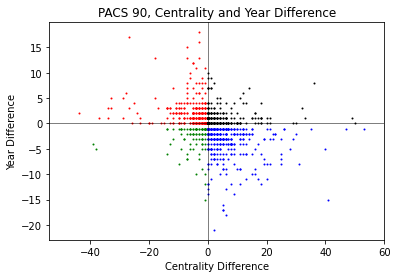

In [ ]:
# build scatterplots

# zeros are included for the graphic reasons - removed for analysis

block13 = homp[homp['yeard'] >= 0]
block24 = homp[homp['yeard'] < 0]

block1 = block13[block13['countd'] >= 0]
block3 = block13[block13['countd'] < 0]
block4 = block24[block24['countd'] >= 0]
block2 = block24[block24['countd'] < 0]

plt.title("PACS 90, Centrality and Year Difference")
plt.scatter(block1.countd, block1.yeard, s=1, c='black')
plt.scatter(block2.countd, block2.yeard, s=1, c='g')
plt.scatter(block3.countd, block3.yeard, s=1, c='r')
plt.scatter(block4.countd, block4.yeard, s=1, c='b')
plt.axhline(y=0, linewidth=0.5, c='k')
plt.axvline(x=0, linewidth=0.5, c='k')
plt.xlabel("Centrality Difference")
plt.ylabel("Year Difference")
plt.xlim(xmax=60)
# plt.xlim(xmin=-100)

In [ ]:
# remove zeros

block13 = homp[homp['yeard'] > 0]
block1 = block13[block13['countd'] > 0]
block4 = block24[block24['countd'] > 0]

In [ ]:
comp13 = []

for i in range(1,11):
  b1 = block1[block1['yeard'] == i]
  b3 = block3[block3['yeard'] == i]
  if len(b1) < 2 or len(b3) < 2:
    print('NA')
    comp13.append('NA')
  else:
    xd = b1['countd'].mean() - b3['countd'].mean()
    var = math.sqrt(statistics.stdev(b1['countd'])**2 +
                    statistics.stdev(b3['countd'])**2)

    print(xd/var)
    comp13.append(xd/var)

1.173904865318404
1.3022159413231136
1.1330136358908969
1.7247474636694409
1.568292470721645
NA
1.375597058468528
0.9274746114093078
NA
NA


In [ ]:
comp42 = []

for i in range(1,11):
  b4 = block4[block4['yeard'] == -i]
  b2 = block2[block2['yeard'] == -i]
  if len(b4) < 2 or len(b2) < 2:
    print('NA')
    comp13.append('NA')
  else:
    xd = b4['countd'].mean() - b2['countd'].mean()
    var = math.sqrt(statistics.stdev(b4['countd'])**2 +
                    statistics.stdev(b2['countd'])**2)

    print(xd/var)
    comp42.append(xd/var)

1.1804039165593339
0.6632428273111366
1.5520982515720987
0.846809132799925
1.0160064584282458
1.8980224257908334
0.6300702520805452
NA
NA
1.9654188579355578


# 2. Gender citing gender (setup)

In [ ]:
############## SELECT DESIRED PACS (HOMOPHILY ONLY) ###############

homn = pd.read_csv("drive/My Drive/codes/hom0.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom1.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom2.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom3.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom4.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom5.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom6.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom7.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom8.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom9.csv")

In [ ]:
homn.head()

,paper1,gender1,year1,paper2,gender2,year2,qval,k
0,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.34.1617,male,1986,0.001230,False
1,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.34.4472,female,1986,0.017857,False
2,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.41.784,male,1990,0.017857,False
3,10.1103/PhysRevA.34.4472,female,1986,10.1103/PhysRevA.41.784,male,1990,0.017857,False
4,10.1103/PhysRevA.36.4950,female,1987,10.1103/PhysRevA.41.784,male,1990,0.006410,False


In [ ]:
testhom = homn.drop(['year1', 'year2', 'k'], axis=1)

testcen = cen.rename({'citing_doi': 'cit', 'citing_gender': 'cgender',
                          'cited_doi': 'paper', 'cited_gender': 'pgender'},
                          axis=1)

testhom = testhom[testhom['gender1'] != testhom['gender2']]

In [ ]:
test = pd.merge(testcen, testhom, left_on='paper', right_on='paper1',
                how='inner').drop(['paper', 'pgender'], axis=1).rename(
                    {'cit': 'cit1', 'cgender': 'cgen1'}, axis=1)

test = test.merge(testcen, left_on='paper2',
                  right_on='paper', how='inner').drop(
                      ['paper', 'pgender'], axis=1).rename(
                          {'cit': 'cit2', 'cgender': 'cgen2'}, axis=1)
test = test[['cit1', 'cgen1', 'cit2', 'cgen2', 'paper1', 'gender1', 'paper2',
             'gender2', 'qval']]

test.head()

,cit1,cgen1,cit2,cgen2,paper1,gender1,paper2,gender2,qval
0,10.1103/PhysRevLett.101.180602,male,10.1103/PhysRevLett.103.153004,male,10.1103/PhysRevA.77.022111,male,10.1103/PhysRevLett.102.063002,female,0.142857
1,10.1103/PhysRevB.80.174103,male,10.1103/PhysRevLett.103.153004,male,10.1103/PhysRevA.77.022111,male,10.1103/PhysRevLett.102.063002,female,0.142857
2,10.1103/PhysRevA.78.016102,male,10.1103/PhysRevLett.103.153004,male,10.1103/PhysRevA.77.022111,male,10.1103/PhysRevLett.102.063002,female,0.142857
3,10.1103/RevModPhys.81.1051,male,10.1103/PhysRevLett.103.153004,male,10.1103/PhysRevA.70.023414,male,10.1103/PhysRevLett.102.063002,female,0.008621
4,10.1103/PhysRevLett.103.130401,male,10.1103/PhysRevLett.103.153004,male,10.1103/PhysRevA.70.023414,male,10.1103/PhysRevLett.102.063002,female,0.008621


In [ ]:
plist = []

plist.append(1)
pcount = 1

for i in tqdm(range(len(test)-1)):
  if test['paper1'][i+1] == test['paper1'][i] and test['paper2'][i+1] == test['paper2'][i]:
    pcount += 0
  else:
    pcount += 1
  plist.append(pcount)

test['pair'] = plist

In [ ]:
test.head()

,cit1,cgen1,cit2,cgen2,paper1,gender1,paper2,gender2,qval,pair
0,10.1103/PhysRevLett.101.180602,male,10.1103/PhysRevLett.103.153004,male,10.1103/PhysRevA.77.022111,male,10.1103/PhysRevLett.102.063002,female,0.142857,1
1,10.1103/PhysRevB.80.174103,male,10.1103/PhysRevLett.103.153004,male,10.1103/PhysRevA.77.022111,male,10.1103/PhysRevLett.102.063002,female,0.142857,1
2,10.1103/PhysRevA.78.016102,male,10.1103/PhysRevLett.103.153004,male,10.1103/PhysRevA.77.022111,male,10.1103/PhysRevLett.102.063002,female,0.142857,1
3,10.1103/RevModPhys.81.1051,male,10.1103/PhysRevLett.103.153004,male,10.1103/PhysRevA.70.023414,male,10.1103/PhysRevLett.102.063002,female,0.008621,2
4,10.1103/PhysRevLett.103.130401,male,10.1103/PhysRevLett.103.153004,male,10.1103/PhysRevA.70.023414,male,10.1103/PhysRevLett.102.063002,female,0.008621,2


In [ ]:
########### CHANGE NUMBERS ACCORDINGLY ###########

mm1list = [1]
mf1list = [0]
fm1list = [0]
ff1list = [0]

mm1 = 1
mf1 = 0
fm1 = 0
ff1 = 0

for i in tqdm(range(1, len(test))):
  if test['pair'][i] == test['pair'][i-1]:
    if test['cit1'][i] != test['cit1'][i-1]:
      if test['cgen1'][i] == 'male':
        if test['gender1'][i] == 'male':
          mm1 += 1
        else:
          mf1 += 1
      else:
        if test['gender1'][i] == 'male':
          fm1 += 1
        else:
          ff1 += 1
  else:
    mm1 = 0
    mf1 = 0
    fm1 = 0
    ff1 = 0
    if test['cgen1'][i] == 'male':
      if test['gender1'][i] == 'male':
        mm1 += 1
      else:
        mf1 += 1
    else:
      if test['gender1'][i] == 'male':
        fm1 += 1
      else:
        ff1 += 1
  mm1list.append(mm1)
  mf1list.append(mf1)
  fm1list.append(fm1)
  ff1list.append(ff1)

KeyboardInterrupt: ignored

In [ ]:
########### CHANGE NUMBERS ACCORDINGLY ###########

mm2list = [0]
mf2list = [0]
fm2list = [0]
ff2list = [1]

mm2 = 0
mf2 = 0
fm2 = 0
ff2 = 1

for i in tqdm(range(1, len(test))):
  if test['pair'][i] == test['pair'][i-1]:
    if test['cit2'][i] != test['cit2'][i-1]:
      if test['cgen2'][i] == 'male':
        if test['gender2'][i] == 'male':
          mm2 += 1
        else:
          mf2 += 1
      else:
        if test['gender2'][i] == 'male':
          fm2 += 1
        else:
          ff2 += 1
  else:
    mm2 = 0
    mf2 = 0
    fm2 = 0
    ff2 = 0
    if test['cgen2'][i] == 'male':
      if test['gender2'][i] == 'male':
        mm2 += 1
      else:
        mf2 += 1
    else:
      if test['gender2'][i] == 'male':
        fm2 += 1
      else:
        ff2 += 1
  mm2list.append(mm2)
  mf2list.append(mf2)
  fm2list.append(fm2)
  ff2list.append(ff2)

In [ ]:
mmlist = [mm1list[i] + mm2list[i] for i in range(len(mm1list))]
mflist = [mf1list[i] + mf2list[i] for i in range(len(mf1list))]
fmlist = [fm1list[i] + fm2list[i] for i in range(len(fm1list))]
fflist = [ff1list[i] + ff2list[i] for i in range(len(ff1list))] 

In [ ]:
test['mm'] = mmlist
test['mf'] = mflist
test['fm'] = fmlist
test['ff'] = fflist

test.head(30)

,cit1,cgen1,cit2,cgen2,paper1,gender1,paper2,gender2,qval,pair,mm,mf,fm,ff
0,10.1103/PhysRevB.48.12110,male,10.1103/PhysRevB.73.165406,female,10.1103/PhysRevB.48.2721,male,10.1103/PhysRevB.62.2813,female,0.005405,1,1,0,0,1
1,10.1103/PhysRevB.48.12110,male,10.1103/PhysRevB.79.014111,male,10.1103/PhysRevB.48.2721,male,10.1103/PhysRevB.62.2813,female,0.005405,1,1,1,0,1
2,10.1103/PhysRevB.48.12110,male,10.1103/PhysRevB.72.115424,male,10.1103/PhysRevB.48.2721,male,10.1103/PhysRevB.62.2813,female,0.005405,1,1,2,0,1
3,10.1103/PhysRevB.48.12110,male,10.1103/PhysRevB.65.012107,male,10.1103/PhysRevB.48.2721,male,10.1103/PhysRevB.62.2813,female,0.005405,1,1,3,0,1
4,10.1103/PhysRevB.48.12110,male,10.1103/PhysRevB.65.195413,female,10.1103/PhysRevB.48.2721,male,10.1103/PhysRevB.62.2813,female,0.005405,1,1,3,0,2
5,10.1103/PhysRevB.48.12110,male,10.1103/PhysRevB.64.174105,male,10.1103/PhysRevB.48.2721,male,10.1103/PhysRevB.62.2813,female,0.005405,1,1,4,0,2
6,10.1103/PhysRevB.48.12110,male,10.1103/PhysRevLett.86.5735,female,10.1103/PhysRevB.48.2721,male,10.1103/PhysRevB.62.2813,female,0.005405,1,1,4,0,3
7,10.1103/PhysRevB.52.16476,male,10.1103/PhysRevB.73.165406,female,10.1103/PhysRevB.48.2721,male,10.1103/PhysRevB.62.2813,female,0.005405,1,2,4,0,4
8,10.1103/PhysRevB.52.16476,male,10.1103/PhysRevB.79.014111,male,10.1103/PhysRevB.48.2721,male,10.1103/PhysRevB.62.2813,female,0.005405,1,2,5,0,4
9,10.1103/PhysRevB.52.16476,male,10.1103/PhysRevB.72.115424,male,10.1103/PhysRevB.48.2721,male,10.1103/PhysRevB.62.2813,female,0.005405,1,2,6,0,4


In [ ]:
test = test.drop_duplicates(['pair'], keep='last', ignore_index=True)

In [ ]:
test.to_csv(r'drive/My Drive/codes/test80.csv',index=False)

# 3. Gender citing gender

In [ ]:
############## SELECT DESIRED PACS (HOMOPHILY ONLY) ###############

# testn = pd.read_csv("drive/My Drive/codes/test00.csv")
# testn = pd.read_csv("drive/My Drive/codes/test10.csv")
# testn = pd.read_csv("drive/My Drive/codes/test20.csv")
# testn = pd.read_csv("drive/My Drive/codes/test30.csv")
# testn = pd.read_csv("drive/My Drive/codes/test40.csv")
# testn = pd.read_csv("drive/My Drive/codes/test50.csv")
# testn = pd.read_csv("drive/My Drive/codes/test60.csv")
# testn = pd.read_csv("drive/My Drive/codes/test70.csv")
testn = pd.read_csv("drive/My Drive/codes/test80.csv")
# testn = pd.read_csv("drive/My Drive/codes/test90.csv")

In [ ]:
testn.head()

,cit1,cgen1,cit2,cgen2,paper1,gender1,paper2,gender2,qval,pair,mm,mf,fm,ff
0,10.1103/PhysRevLett.71.4130,male,10.1103/PhysRevLett.86.5735,female,10.1103/PhysRevB.48.2721,male,10.1103/PhysRevB.62.2813,female,0.005405,1,10,40,0,30
1,10.1103/PhysRevLett.71.4130,male,10.1103/PhysRevLett.86.5735,female,10.1103/PhysRevB.45.1988,male,10.1103/PhysRevB.62.2813,female,0.005405,2,10,40,0,30
2,10.1103/PhysRevB.69.115406,male,10.1103/PhysRevLett.86.5735,female,10.1103/PhysRevB.60.13890,male,10.1103/PhysRevB.62.2813,female,0.001493,3,1,8,1,6
3,10.1103/PhysRevB.69.115406,male,10.1103/PhysRevLett.86.5735,female,10.1103/PhysRevB.55.10931,male,10.1103/PhysRevB.62.2813,female,0.001493,4,3,20,2,15
4,10.1103/PhysRevB.69.115406,male,10.1103/PhysRevLett.86.5735,female,10.1103/PhysRevB.50.1912,male,10.1103/PhysRevB.62.2813,female,0.005405,5,5,28,2,21


In [ ]:
mlist = []

for i in tqdm(range(len(testn))):
  if testn['mm'][i] + testn['mf'][i] == 0:
    mlist.append(0)
  else:
    mlist.append(testn['mm'][i] / (testn['mm'][i] + testn['mf'][i]))

In [ ]:
flist = []

for i in tqdm(range(len(testn))):
  if testn['fm'][i] + testn['ff'][i] == 0:
    flist.append(0)
  else:
    flist.append(testn['ff'][i] / (testn['fm'][i] + testn['ff'][i]))

In [ ]:
testn['f(mm)'] = mlist
testn['f(ff)'] = flist

testn = testn.drop(['cit1', 'cgen1', 'cit2', 'cgen2', 'paper1', 'gender1',
                    'paper2', 'gender2', 'mm', 'mf', 'fm', 'ff'],axis=1)
testn = testn[['pair', 'f(mm)', 'f(ff)', 'qval']]

In [ ]:
print(statistics.mean(testn['f(mm)']))
print(scipy.stats.sem(testn['f(mm)'], axis=None))
print(statistics.mean(testn['f(ff)']))
print(scipy.stats.sem(testn['f(ff)'], axis=None))

0.5312174745151974
0.0028313379111416064
0.5504773316700978
0.003659752025751442


# 3' Overall GCG Statistics

In [ ]:
test0 = pd.read_csv("drive/My Drive/codes/test00.csv")
test1 = pd.read_csv("drive/My Drive/codes/test10.csv")
test2 = pd.read_csv("drive/My Drive/codes/test20.csv")
test3 = pd.read_csv("drive/My Drive/codes/test30.csv")
test4 = pd.read_csv("drive/My Drive/codes/test40.csv")
test5 = pd.read_csv("drive/My Drive/codes/test50.csv")
test6 = pd.read_csv("drive/My Drive/codes/test60.csv")
test7 = pd.read_csv("drive/My Drive/codes/test70.csv")
test8 = pd.read_csv("drive/My Drive/codes/test80.csv")
test9 = pd.read_csv("drive/My Drive/codes/test90.csv")

In [ ]:
testn = pd.concat([test0, test1, test2, test3, test4, test5, test6, test7, test8, test9])
testn = testn.drop(['cit1', 'cgen1', 'cit2', 'cgen2', 'paper1', 'gender1',
                    'paper2', 'gender2', 'qval'],axis=1).reset_index(drop=True)

In [ ]:
mlist = []

for i in tqdm(range(len(testn))):
  if testn['mm'][i] + testn['mf'][i] == 0:
    mlist.append(0)
  else:
    mlist.append(testn['mm'][i] / (testn['mm'][i] + testn['mf'][i]))

In [ ]:
flist = []

for i in tqdm(range(len(testn))):
  if testn['fm'][i] + testn['ff'][i] == 0:
    flist.append(0)
  else:
    flist.append(testn['ff'][i] / (testn['fm'][i] + testn['ff'][i]))

In [ ]:
testn['f(mm)'] = mlist
testn['f(ff)'] = flist

testn = testn.drop(['mm', 'mf', 'fm', 'ff', 'pair'],axis=1)
testn = testn[['f(mm)', 'f(ff)']]

In [ ]:
testn.tail(50)

,f(mm),f(ff)
612646,0.941176,0.000000
612647,0.916667,0.000000
612648,0.800000,0.000000
612649,0.869565,1.000000
612650,0.943396,0.285714
612651,0.857143,0.000000
612652,0.666667,0.000000
612653,0.250000,1.000000
612654,0.727273,1.000000
612655,1.000000,1.000000


In [ ]:
print(statistics.mean(testn['f(mm)']))
print(statistics.stdev(testn['f(mm)']))
print(scipy.stats.sem(testn['f(mm)'], axis=None))
print(statistics.mean(testn['f(ff)']))
print(statistics.stdev(testn['f(ff)']))
print(scipy.stats.sem(testn['f(ff)'], axis=None))

0.565876193024013
0.35442846390261723
0.00045279963696561235
0.5511226826457528
0.4648967280083133
0.0005939282284238425
